In [54]:
import pandas as pd
import numpy as np
df = pd.read_csv("dropout.csv")
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [55]:
df = df[df['Target'] != 'Enrolled']
df['Target'] = df['Target'].map({'Graduate': 0, 'Dropout': 1})

In [56]:
cat_cols = [
    'Marital status',
    'Application order',
    'Application mode',
    'Course',
    'Daytime/evening attendance',
    'Previous qualification',
    'Nacionality',
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
    'Displaced',
    'Educational special needs',
    'Debtor',
    'Tuition fees up to date',
    'Gender',
    'Scholarship holder',
    'International'
]
numeric_cols = df.drop(columns=cat_cols)
numeric_cols = numeric_cols.drop(columns=['Target'])

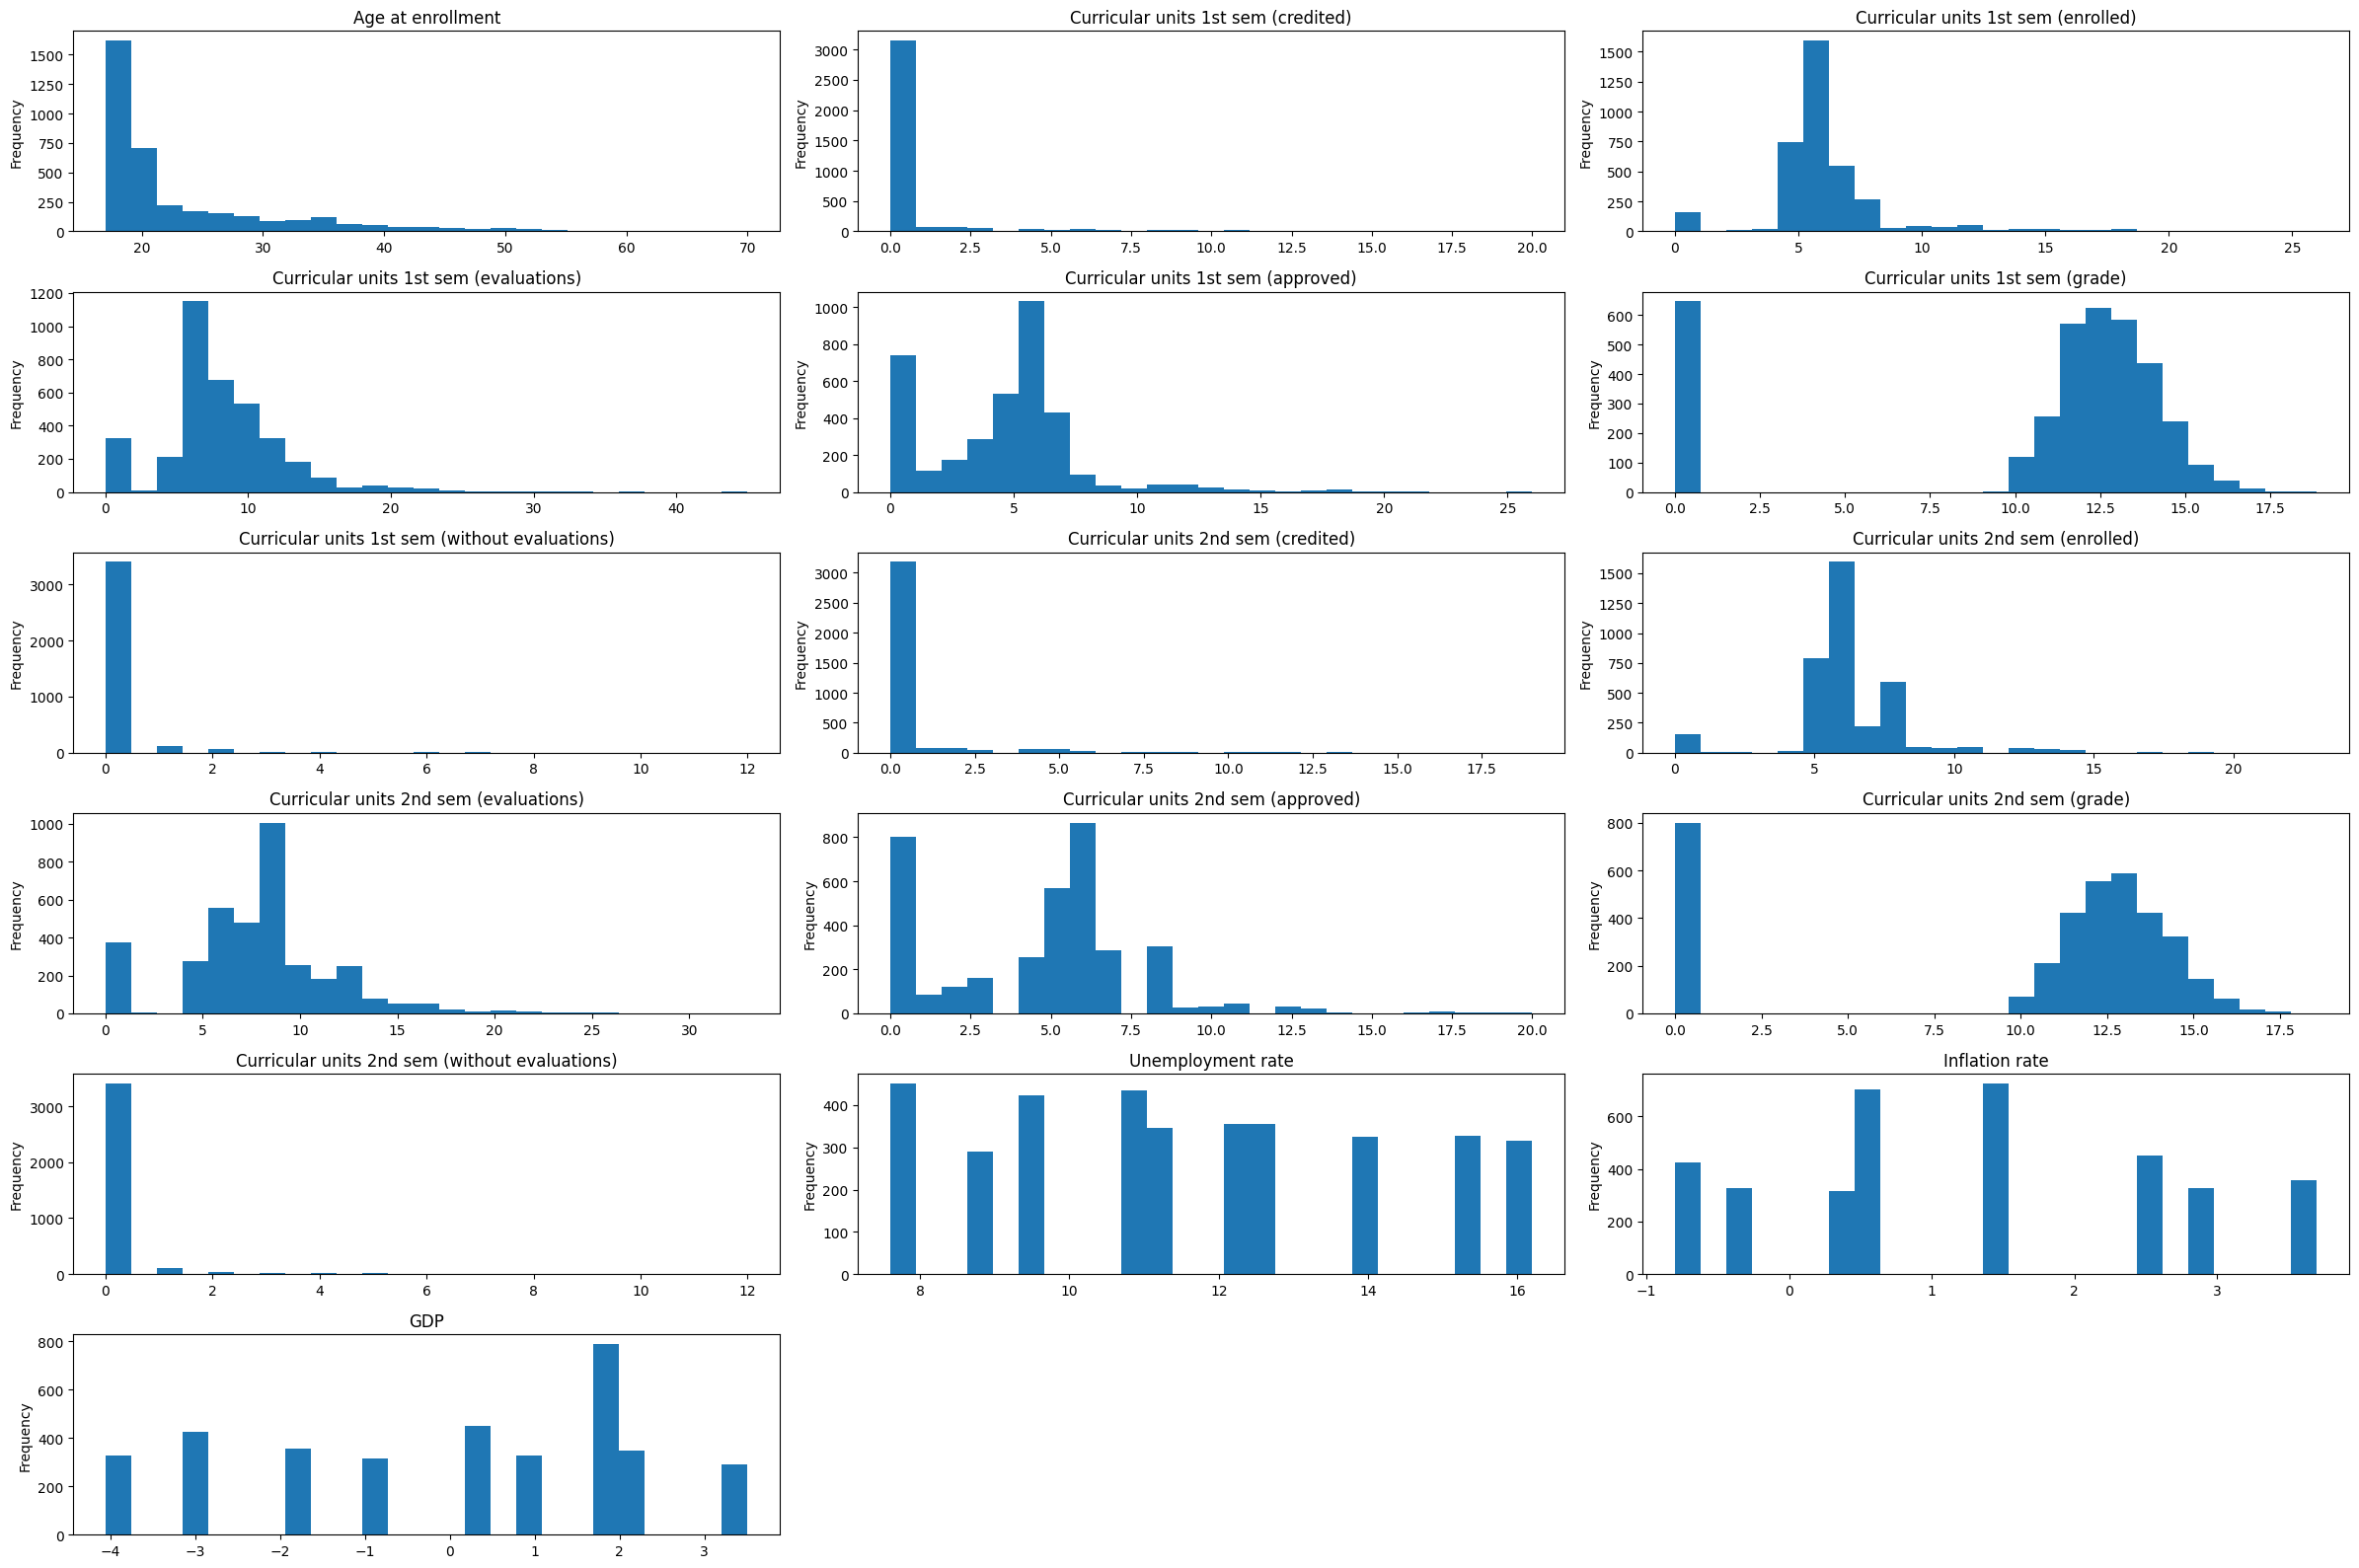

In [57]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(24,16))

i = 0
for column in numeric_cols:
    sub = fig.add_subplot(6,3,i+1)
    sub.set_title(column, fontsize=12)
    sub.set_xlabel("")  
    df[column].plot(kind='hist', bins=25)
    i += 1

plt.tight_layout()

In [58]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2
import numpy as np
X_num = numeric_cols
y = df["Target"]

fs_num = SelectKBest(score_func=f_classif, k='all')
fs_num.fit(X_num, y)

results = pd.DataFrame({
    'Feature': X_num.columns,
    'F_score': fs_num.scores_,
    'p_value': fs_num.pvalues_
}).sort_values('F_score', ascending=False)

print(results[results['p_value'] >= 0.05].to_string(index=False))

          Feature  F_score  p_value
   Inflation rate 3.339591 0.067714
Unemployment rate 0.063941 0.800386


In [59]:
drop = ['Inflation rate', 'Unemployment rate']
df = df.drop(columns=drop)

In [60]:
chi = SelectKBest(score_func=chi2, k='all')
catFeatures = chi.fit(df[cat_cols], y)

results = pd.DataFrame({
    'Feature': df[cat_cols].columns,
    'Chi2': chi.scores_,
    'p_value': chi.pvalues_
}).sort_values('Chi2', ascending=False)


print(results[results['p_value'] >= 0.05].to_string(index=False))

                   Feature     Chi2  p_value
Daytime/evening attendance 2.912942 0.087871
    Father's qualification 0.390080 0.532257
                    Course 0.319566 0.571869
 Educational special needs 0.188890 0.663842
             International 0.135409 0.712888
               Nacionality 0.123420 0.725354


In [61]:
drop_cols = ['Daytime/evening attendance', "Father's qualification", 'Course', 'Educational special needs', 'International', 'Nacionality','GDP','Application order','Curricular units 2nd sem (without evaluations)','Curricular units 1st sem (without evaluations)']
df = df.drop(columns=drop_cols)

In [62]:
X = df.drop(columns=["Target"])
y = df["Target"]

df.columns

Index(['Marital status', 'Application mode', 'Previous qualification',
       'Mother's qualification', 'Mother's occupation', 'Father's occupation',
       'Displaced', 'Debtor', 'Tuition fees up to date', 'Gender',
       'Scholarship holder', 'Age at enrollment',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)', 'Target'],
      dtype='object')

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])
print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("Test target distribution:\n", y_test.value_counts(normalize=True))

Train size: 2541
Test size: 1089
Train target distribution:
 Target
0    0.608422
1    0.391578
Name: proportion, dtype: float64
Test target distribution:
 Target
0    0.608815
1    0.391185
Name: proportion, dtype: float64


In [33]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(
    n_estimators=300,          
    max_depth=4,               
    learning_rate=0.05,     
    subsample=0.8,              
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,          
)

xgb_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [34]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred) 
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
print("Accuracy:  ", f"{acc:.4f}")
print("Precision: ", f"{prec:.4f}")
print("Recall:    ", f"{rec:.4f}")
print("F1-score:  ", f"{f1:.4f}")
print("ROC-AUC:   ", f"{auc:.4f}")



Accuracy:   0.9247
Precision:  0.9343
Recall:     0.8685
F1-score:   0.9002
ROC-AUC:    0.9594


In [35]:
importances = xgb_model.feature_importances_

feat_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

feat_importance.head()

,feature,importance
20,Curricular units 2nd sem (approved),0.355234
8,Tuition fees up to date,0.132635
13,Curricular units 1st sem (enrolled),0.052625
15,Curricular units 1st sem (approved),0.043104
7,Debtor,0.037652


<Figure size 1000x800 with 0 Axes>

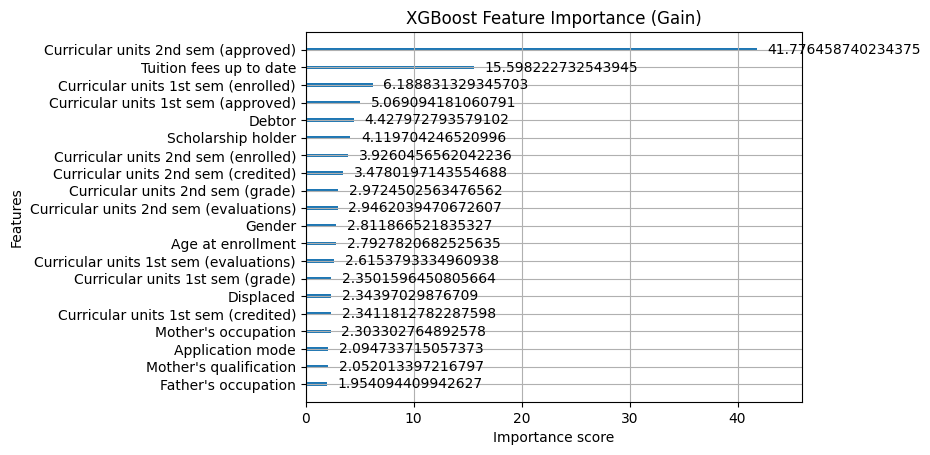

In [36]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, importance_type="gain", max_num_features=20)
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

In [43]:
import pickle
pickle.dump(xgb_model,open("model.pkl", "wb"))

In [44]:
m_status        = 1
app_mode        = 1
prev_qual       = 3
mother_qual     = 2
mother_occ      = 4
father_occ      = 4
displaced       = 0
debtor          = 0
tuition_up      = 1
gender          = 1
scholarship     = 0
age_enroll      = 18
cu1_cred        = 0
cu1_enroll      = 5
cu1_eval        = 5
cu1_approved    = 6
cu1_grade       = 13
cu2_cred        = 0
cu2_enroll      = 5
cu2_eval        = 5
cu2_approved    = 4
cu2_grade       = 14

features = [
    m_status, app_mode, prev_qual, mother_qual, mother_occ,
    father_occ, displaced, debtor, tuition_up, gender, scholarship,
    age_enroll, cu1_cred, cu1_enroll, cu1_eval, cu1_approved,
    cu1_grade, cu2_cred, cu2_enroll, cu2_eval,
    cu2_approved, cu2_grade]

In [45]:
model = pickle.load(open('model.pkl', "rb"))
result = model.predict([features])
prob = model.predict_proba([features])
print(result)
print(prob)

[0]
[[0.9126882  0.08731183]]


Predicted "Graduate" with a 91% success rate.